In [299]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np
import re
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import mannwhitneyu
from scipy import stats
import matplotlib.ticker as ticker
import os
from reload_recursive import reload_recursive
import patsy

from mri_data import file_manager as fm
import helpers

In [20]:
reload_recursive(helpers)

In [21]:
drive_root = fm.get_drive_root()
msmri_home = Path("/home/srs-9/Projects/ms_mri")
msmri_datadir = msmri_home / "data"
curr_dir = Path(os.getcwd())
data_dir = curr_dir / "data"

In [25]:
df = pd.read_csv(data_dir / "t1_data_full.csv")
df = df.set_index("subid")

In [26]:
df = helpers.set_dz_type5(df)
df = helpers.set_dz_type3(df)
df = helpers.fix_edss(df)
df = helpers.clean_df(df)

In [ ]:
keep_cols = [
    "subject",
    "age",
    "sex",
    "ms_type",
    "dz_type3",
    "dz_type5",
    "dzdur",
    "EDSS",
    "MSSS",
    "gMSSS",
    "ARMSS",
    "DMT_score",
    "DMT_hx_all",
    "flair_contrast",
    "lesion_count",
    "lesion_vol_cubic",
    "PRL",
    "tiv",
    "choroid_volume",
]

df = df.loc[:, keep_cols]
df = pd.concat((df, pd.get_dummies(df["sex"])), axis=1)

(array([  6.,  23.,  61., 114., 111.,  89.,  40.,  18.,  11.,  19.]),
 array([-0.73551597, -0.49787074, -0.26022551, -0.02258027,  0.21506496,
         0.45271019,  0.69035542,  0.92800065,  1.16564588,  1.40329112,
         1.64093635]),
 <BarContainer object of 10 artists>)

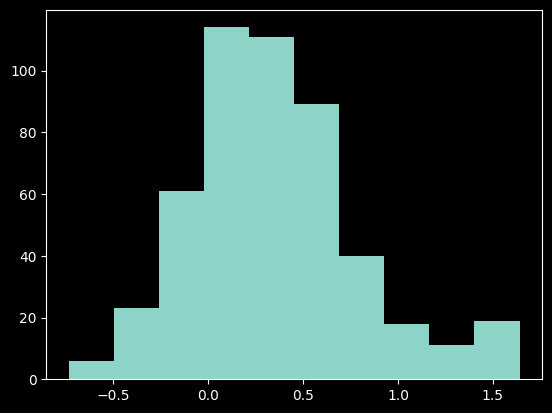

In [30]:
df.loc[:, "lesion_vol_logtrans"] = np.log(df["lesion_vol_cubic"])
plt.hist(df["lesion_vol_logtrans"])

(array([ 12.,   0.,   2.,  71., 180.,  54.,  38.,  19.,  56.,  10.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

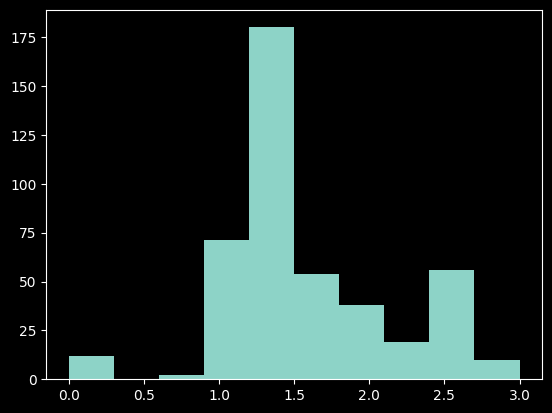

In [32]:
df.loc[:, "edss_sqrt"] = np.sqrt(df["EDSS"].astype("float"))
plt.hist(df["edss_sqrt"])

(array([ 8., 35., 49., 58., 53., 55., 51., 43., 28., 23.]),
 array([0.2236068 , 0.51684079, 0.81007479, 1.10330879, 1.39654279,
        1.68977678, 1.98301078, 2.27624478, 2.56947877, 2.86271277,
        3.15594677]),
 <BarContainer object of 10 artists>)

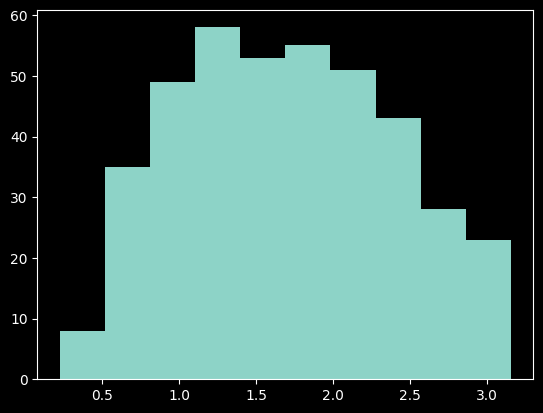

In [33]:
df.loc[:, "msss_sqrt"] = np.sqrt(df["MSSS"])
plt.hist(df["msss_sqrt"])

(array([10., 28., 65., 60., 69., 60., 53., 39., 32., 24.]),
 array([0.37416574, 0.65155069, 0.92893564, 1.20632059, 1.48370554,
        1.76109049, 2.03847544, 2.3158604 , 2.59324535, 2.8706303 ,
        3.14801525]),
 <BarContainer object of 10 artists>)

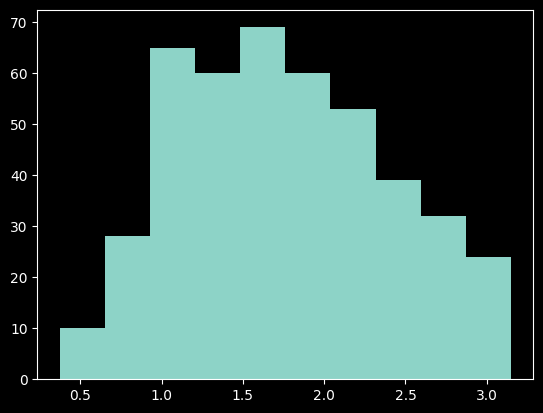

In [34]:
df.loc[:, "armss_sqrt"] = np.sqrt(df["ARMSS"])
plt.hist(df["armss_sqrt"])

In [ ]:
vars = [
    "age",
    "Female",
    "dzdur",
    "EDSS",
    "MSSS",
    "gMSSS",
    "ARMSS",
    "edss_sqrt",
    "msss_sqrt",
    "armss_sqrt",
    "DMT_score",
    "DMT_hx_all",
    "lesion_count",
    "lesion_vol_cubic",
    "lesion_vol_logtrans",
    "PRL",
    "tiv",
    "choroid_volume",
]

In [116]:
data = df.loc[df["dz_type5"].isin(["RMS", "PMS"]), :]
data = data[vars].astype("float")
data = data.dropna()
data_z = data[vars].apply(stats.zscore)

In [ ]:
from statsmodels.stats.mediation import Mediation
from pingouin import mediation_analysis

## CP Volums as Outcome

In [291]:
outcome_model = sm.OLS.from_formula(
    "choroid_volume ~  age + tiv + Female", data=data
)

res = outcome_model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         choroid_volume   R-squared:                       0.253
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     42.00
Date:                Sun, 16 Feb 2025   Prob (F-statistic):           2.13e-23
Time:                        21:25:24   Log-Likelihood:                -2931.8
No. Observations:                 376   AIC:                             5872.
Df Residuals:                     372   BIC:                             5887.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    470.9280    492.995      0.955      0.3

## EDSS as Outcome

### lesion volume mediating choroid volume effect

Choroid enlargement is a sign of inflammation, which causes WML (ie demyelination) and resultant disability

In [297]:
outcome_model = sm.OLS.from_formula(
    "edss_sqrt ~ choroid_volume + lesion_vol_logtrans + age + tiv + Female", data=data
)
mediator_model = sm.OLS.from_formula(
    "lesion_vol_logtrans ~ choroid_volume + age + tiv + Female", data=data
)

med = Mediation(
    outcome_model, mediator_model, "choroid_volume", "lesion_vol_logtrans"
).fit()
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),-0.000071,-0.015238,0.013597,0.998
ACME (treated),-0.000071,-0.015238,0.013597,0.998
ADE (control),0.000045,-0.000047,0.000136,0.348
ADE (treated),0.000045,-0.000047,0.000136,0.348
Total effect,-0.000026,-0.015200,0.013659,0.994
Prop. mediated (control),0.999048,0.868934,1.152102,0.004
Prop. mediated (treated),0.999048,0.868934,1.152102,0.004
ACME (average),-0.000071,-0.015238,0.013597,0.998
ADE (average),0.000045,-0.000047,0.000136,0.348
Prop. mediated (average),0.999048,0.868934,1.152102,0.004


In [301]:
outcome = np.asarray(data['edss_sqrt'])
outcome_exog = patsy.dmatrix("choroid_volume + lesion_vol_logtrans + age + tiv + Female",
                             data, return_type="dataframe")
outcome_model = sm.OLS(outcome, outcome_exog)

mediator = np.asarray(data['lesion_vol_logtrans'])
mediator_exog = patsy.dmatrix("choroid_volume + age + tiv + Female", data, return_type="dataframe")
mediator_model = sm.OLS(mediator, mediator_exog)

tx_pos = [outcome_exog.columns.tolist().index("choroid_volume"),
          mediator_exog.columns.tolist().index("choroid_volume")]
med_pos = outcome_exog.columns.tolist().index("lesion_vol_logtrans")
med = Mediation(outcome_model, mediator_model, tx_pos, med_pos).fit()
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),0.000148,-0.013462,0.013539,0.996
ACME (treated),0.000148,-0.013462,0.013539,0.996
ADE (control),0.000046,-0.000044,0.000136,0.352
ADE (treated),0.000046,-0.000044,0.000136,0.352
Total effect,0.000194,-0.013442,0.013562,0.982
Prop. mediated (control),0.999486,0.863230,1.121656,0.014
Prop. mediated (treated),0.999486,0.863230,1.121656,0.014
ACME (average),0.000148,-0.013462,0.013539,0.996
ADE (average),0.000046,-0.000044,0.000136,0.352
Prop. mediated (average),0.999486,0.863230,1.121656,0.014


In [ ]:
mediation_analysis(
    data=data,
    x="choroid_volume",
    m="lesion_vol_logtrans",
    y="edss_sqrt",
    covar=["Female", "age", "tiv"],
    alpha=0.05,
    n_boot=1000,
)

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,lesion_vol_logtrans ~ X,0.000231,0.000032,3.327506e-12,0.000168,0.000294,Yes
1,Y ~ lesion_vol_logtrans,0.270675,0.066770,6.141902e-05,0.139379,0.401971,Yes
2,Total,0.000101,0.000045,2.493365e-02,0.000013,0.000189,Yes
3,Direct,0.000043,0.000047,3.561357e-01,-0.000049,0.000136,No
4,Indirect,0.000057,0.000020,0.000000e+00,0.000025,0.000100,Yes


### lesion_vol mediating PRL

In [176]:
outcome_model = sm.OLS.from_formula(
    "edss_sqrt ~ PRL + lesion_vol_logtrans + age + Female", data=data
)

mediator_model = sm.OLS.from_formula(
    "lesion_vol_logtrans ~ PRL + age + Female", data=data
)

med = Mediation(outcome_model, mediator_model, "PRL", "lesion_vol_logtrans").fit()
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),0.012891,-0.001571,0.031169,0.074
ACME (treated),0.012891,-0.001571,0.031169,0.074
ADE (control),0.024373,-0.003620,0.053294,0.100
ADE (treated),0.024373,-0.003620,0.053294,0.100
Total effect,0.037264,0.006950,0.069626,0.014
Prop. mediated (control),0.329366,-0.080768,1.146631,0.084
Prop. mediated (treated),0.329366,-0.080768,1.146631,0.084
ACME (average),0.012891,-0.001571,0.031169,0.074
ADE (average),0.024373,-0.003620,0.053294,0.100
Prop. mediated (average),0.329366,-0.080768,1.146631,0.084


In [177]:
mediation_analysis(
    data=data,
    x="PRL",
    m="lesion_vol_logtrans",
    y="edss_sqrt",
    covar=["Female", "age", "tiv"],
    alpha=0.05,
    n_boot=500,
)

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,lesion_vol_logtrans ~ X,0.053151,0.011005,0.000002,0.031511,0.074791,Yes
1,Y ~ lesion_vol_logtrans,0.270675,0.066770,0.000061,0.139379,0.401971,Yes
2,Total,0.038626,0.014776,0.009309,0.009572,0.067681,Yes
3,Direct,0.025764,0.015004,0.086791,-0.003740,0.055268,No
4,Indirect,0.012863,0.004499,0.000000,0.005743,0.023607,Yes


### PRL mediating choroid_vol

In [ ]:
outcome_model = sm.OLS.from_formula(
    "edss_sqrt ~ PRL + choroid_volume + age + tiv + Female", data=data
)
mediator_model = sm.GLM.from_formula(
    "PRL ~ choroid_volume + age + tiv", data=data, family=sm.families.Poisson()
)

med = Mediation(outcome_model, mediator_model, "choroid_volume", "PRL").fit()
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),0.000016,-0.002505,0.002534,0.984
ACME (treated),0.000016,-0.002505,0.002534,0.988
ADE (control),0.000076,-0.000018,0.000165,0.096
ADE (treated),0.000076,-0.000018,0.000165,0.096
Total effect,0.000093,-0.002431,0.002591,0.902
Prop. mediated (control),0.978040,-0.382402,2.624894,0.102
Prop. mediated (treated),0.978040,-0.382402,2.624894,0.098
ACME (average),0.000016,-0.002505,0.002534,0.986
ADE (average),0.000076,-0.000018,0.000165,0.096
Prop. mediated (average),0.978040,-0.382402,2.624894,0.096


In [ ]:
mediation_analysis(
    data=data,
    x="choroid_volume",
    m="PRL",
    y="edss_sqrt",
    covar=["Female", "age", "tiv"],
    alpha=0.05,
    n_boot=500,
)

### choroid_vol mediating female

In [174]:
outcome_model = sm.OLS.from_formula(
    "edss_sqrt ~ choroid_volume + tiv + Female", data=data
)
mediator_model = sm.OLS.from_formula("choroid_volume ~ Female + tiv", data=data)

med = Mediation(outcome_model, mediator_model, "Female", "choroid_volume").fit()
med.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),-0.113207,-0.189566,-0.059250,0.000
ACME (treated),-0.113207,-0.189566,-0.059250,0.000
ADE (control),-0.109915,-0.270774,0.052776,0.184
ADE (treated),-0.109915,-0.270774,0.052776,0.184
Total effect,-0.223122,-0.375744,-0.062075,0.006
Prop. mediated (control),0.501841,0.222937,1.689311,0.006
Prop. mediated (treated),0.501841,0.222937,1.689311,0.006
ACME (average),-0.113207,-0.189566,-0.059250,0.000
ADE (average),-0.109915,-0.270774,0.052776,0.184
Prop. mediated (average),0.501841,0.222937,1.689311,0.006


### Misc

In [ ]:
res = sm.GLM.from_formula(
    "PRL ~ lesion_vol_cubic + choroid_volume + age + Female + tiv",
    data=data,
    family=sm.families.Poisson(),
).fit()

print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    PRL   No. Observations:                  376
Model:                            GLM   Df Residuals:                      370
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -540.92
Date:                Sat, 15 Feb 2025   Deviance:                       720.48
Time:                        23:29:18   Pearson chi2:                     958.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3890
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -1.6383      0.859  

In [ ]:
import statsmodels.genmod.families.links as links

res = sm.GLM.from_formula(
    "lesion_vol_cubic ~  PRL + choroid_volume + age + Female + tiv",
    data=data,
    family=sm.families.Gaussian(links.Log()),
).fit()


print(res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:       lesion_vol_cubic   No. Observations:                  439
Model:                            GLM   Df Residuals:                      433
Model Family:                Gaussian   Df Model:                            5
Link Function:                    Log   Scale:                         0.59352
Method:                          IRLS   Log-Likelihood:                -505.41
Date:                Sat, 15 Feb 2025   Deviance:                       257.00
Time:                        22:22:52   Pearson chi2:                     257.
No. Iterations:                     7   Pseudo R-squ. (CS):             0.1442
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.0348      0.355     -0.

In [ ]:
import statsmodels.genmod.families.links as links

res = sm.GLM.from_formula(
    "lesion_vol_logtrans ~  PRL + choroid_volume + age + Female + tiv", data=data
).fit()


print(res.summary())

                  Generalized Linear Model Regression Results                  
Dep. Variable:     lesion_vol_logtrans   No. Observations:                  439
Model:                             GLM   Df Residuals:                      433
Model Family:                 Gaussian   Df Model:                            5
Link Function:                Identity   Scale:                         0.13985
Method:                           IRLS   Log-Likelihood:                -188.10
Date:                 Sat, 15 Feb 2025   Deviance:                       60.557
Time:                         22:24:17   Pearson chi2:                     60.6
No. Iterations:                      3   Pseudo R-squ. (CS):             0.2558
Covariance Type:             nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.2973      0.2

In [93]:
model = sm.OLS.from_formula("edss_sqrt ~ dzdur + age + Female", data=data)
res = model.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              edss_sqrt   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     36.45
Date:                Sat, 15 Feb 2025   Prob (F-statistic):           1.13e-20
Time:                        23:30:22   Log-Likelihood:                -273.99
No. Observations:                 376   AIC:                             556.0
Df Residuals:                     372   BIC:                             571.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8250      0.127      6.484      0.0

## Moderation Analysis

### Functions

In [ ]:
def moderation_y(data, coef, x_name, m_name):
    reg = re.compile(r"(\w+)\:(\w+)")
    regression_data = {}
    for name in coef.index:
        if name == "Intercept":
            continue
        mat = reg.match(name)
        if mat is None:
            regression_data[name] = data[name]
        else:
            regression_data[name] = data[mat[1]] * data[mat[2]]
            inter_name = name
    regression_data = pd.DataFrame(regression_data)

    other_vars = coef.index[~coef.index.isin([x_name, m_name, inter_name, "Intercept"])]
    other_terms = np.sum(coef[other_vars] * regression_data.loc[:, other_vars].mean())

    m_vals = [
        data[m_name].mean() - data[m_name].std(),
        data[m_name].mean(),
        data[m_name].mean() + data[m_name].std(),
    ]
    print(m_vals[0])

    y_lvls = []
    for m_val in m_vals:
        y = (
            data[x_name] * coef[x_name]
            + m_val * coef[m_name]
            + coef[inter_name] * m_val * data[x_name]
            + other_terms
            + coef["Intercept"]
        )
        y_lvls.append(y)

    return y_lvls


def plot_moderation(x_data, y_data, y_lvls):
    plt.scatter(x_data, y_data, s=5)
    plt.plot(x_data, y_lvls[0], label="m-sd", linestyle="--")
    plt.plot(x_data, y_lvls[1], label="m", linestyle="-")
    plt.plot(x_data, y_lvls[2], label="m+sd", linestyle=":")

    plt.legend()

### Analysis

Center variables

In [ ]:
vars_to_center = ["edss_sqrt", "lesion_vol_logtrans", "dzdur", "choroid_volume", "PRL"]

for var in vars_to_center:
    data.loc[:, f"{var}_cent"] = data[var] - data[var].mean()

centered_vars = [f"{var}_cent" for var in vars_to_center]

In [155]:
data_z = data[vars + centered_vars].apply(stats.zscore)

Do those with greater lesion volume accumulate disability faster?

In [293]:
moderation_model = sm.OLS.from_formula(
    "edss_sqrt ~ lesion_vol_logtrans_cent*dzdur_cent + tiv + age + Female", data=data
)

res = moderation_model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              edss_sqrt   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     22.11
Date:                Sun, 16 Feb 2025   Prob (F-statistic):           3.08e-22
Time:                        21:53:38   Log-Likelihood:                -264.71
No. Observations:                 376   AIC:                             543.4
Df Residuals:                     369   BIC:                             570.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

Index(['Intercept', 'lesion_vol_logtrans_cent', 'dzdur_cent',
       'lesion_vol_logtrans_cent:dzdur_cent', 'tiv', 'age', 'Female'],
      dtype='object')
-0.41668337909796294


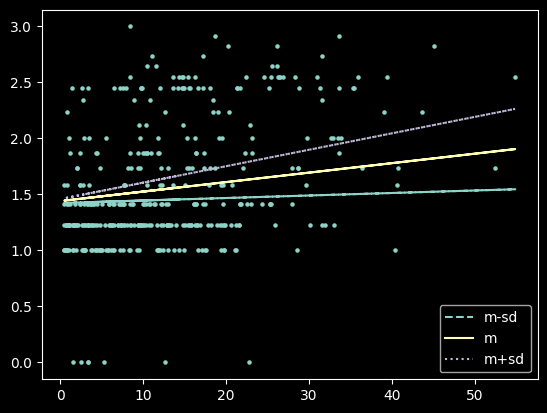

In [267]:
y_lvls = moderation_y(data, res.params, "dzdur_cent", "lesion_vol_logtrans_cent")
plot_moderation(data['dzdur'], data['edss_sqrt'], y_lvls)

In [ ]:
outcome_model = sm.OLS.from_formula(
    "edss_sqrt ~ lesion_vol_cubic + PRL + tiv + age + Female", data=data
)

res = outcome_model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              edss_sqrt   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.223
Method:                 Least Squares   F-statistic:                     18.96
Date:                Mon, 17 Feb 2025   Prob (F-statistic):           2.94e-19
Time:                        14:24:44   Log-Likelihood:                -271.93
No. Observations:                 376   AIC:                             557.9
Df Residuals:                     369   BIC:                             585.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

## Ordinal Regression on EDSS

In [268]:
from statsmodels.miscmodels.ordinal_model import OrderedModel

In [274]:
mod_prob = OrderedModel.from_formula("EDSS ~ lesion_vol_logtrans_cent*dzdur_cent + tiv + age + Female",
                                     data=data, distr='probit')
res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()

/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/scipy/optimize/_optimize.py:1291: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/srs-9/.virtualenvs/monai/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 2.161197
         Iterations: 69
         Function evaluations: 140
         Gradient evaluations: 128


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                   EDSS   Log-Likelihood:                -812.61
Model:                   OrderedModel   AIC:                             1671.
Method:            Maximum Likelihood   BIC:                             1762.
Date:                Sun, 16 Feb 2025                                         
Time:                        21:11:36                                         
No. Observations:                 376                                         
Df Residuals:                     353                                         
Df Model:                           6                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
lesion_vol_logtrans_cent                0.4527      0.139      3.253      0.001       0.180       0.725
dzdur_cent                              0.0159      0.007      2.282      0.023       0.002       0.030
lesion_vol_logtrans_cent:dzdur_cent     0.0292      0.013      2.262      0.024       0.004       0.055
tiv                                  -5.61e-07   1.35e-07     -4.151      0.000   -8.26e-07   -2.96e-07
age                                     0.0269      0.006      4.806      0.000       0.016       0.038
Female                                 -0.2093      0.126     -1.655      0.098      -0.457       0.039
0.0/1.0                                -2.0128      0.327     -6.153      0.000      -2.654      -1.372
1.0/1.5                                 0.2238      0.130      1.725      0.085      -0.030       0.478
1.5/2.0                                -0.1341      0.089     -1.506      0.132      -0.309       0.040
2.0/2.5                                -0.7671      0.121     -6.322      0.000      -1.005      -0.529
2.5/3.0                                -1.7704      0.217     -8.167      0.000      -2.195      -1.346
3.0/3.5                                -1.6303      0.206     -7.920      0.000      -2.034      -1.227
3.5/4.0                                -1.6952      0.222     -7.635      0.000      -2.130      -1.260
4.0/4.5                                -1.7686      0.242     -7.293      0.000      -2.244      -1.293
4.5/5.0                                -3.0993      0.496     -6.250      0.000      -4.071      -2.127
5.0/5.5                                -2.5018      0.372     -6.719      0.000      -3.232      -1.772
5.5/6.0                                -2.7852      0.442     -6.301      0.000      -3.652      -1.919
6.0/6.5                                -0.7253      0.171     -4.235      0.000      -1.061      -0.390
6.5/7.0                                -0.6046      0.216     -2.803      0.005      -1.027      -0.182
7.0/7.5                                -1.6484      0.487     -3.382      0.001      -2.604      -0.693
7.5/8.0                                -1.5648      0.562     -2.782      0.005      -2.667      -0.462
8.0/8.5                                -1.1249      0.556     -2.022      0.043      -2.215      -0.034
8.5/9.0                                -0.9756      0.692     -1.409      0.159      -2.332       0.381
=======================================================================================================
"""

## MSSS and ARMSS

In [283]:
outcome_model = sm.OLS.from_formula(
    "armss_sqrt ~ choroid_volume + tiv + Female", data=data
)

res = outcome_model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             armss_sqrt   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.2786
Date:                Sun, 16 Feb 2025   Prob (F-statistic):              0.841
Time:                        21:19:03   Log-Likelihood:                -361.25
No. Observations:                 376   AIC:                             730.5
Df Residuals:                     372   BIC:                             746.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.8862      0.504      3.